All data maniupulation done in SQL, no pandas allowed.

In [1]:
import pymysql
import toml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def query_db(query, conn):
    with conn.cursor() as cur:
        cur.execute(query)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=[i[0] for i in cur.description])
    return df

In [3]:
# Load secrets from .streamlit/secrets.toml
secrets = toml.load(".streamlit/secrets.toml")["connections"]["mysql"]

# Connect to the mysql database
conn = pymysql.connect(
    host=secrets["host"],
    port=secrets["port"],
    database=secrets["dbname"],
    user=secrets["username"],
    password=secrets["password"]
)

In [4]:
df = query_db("""
    SELECT 
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type, 
        year(startTimeLocal) AS year, 
        CAST(duration AS FLOAT)/3600 duration_hr, 
        CAST(distance AS FLOAT) distance 
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year BETWEEN 2022 AND 2025
    """,
    conn
)


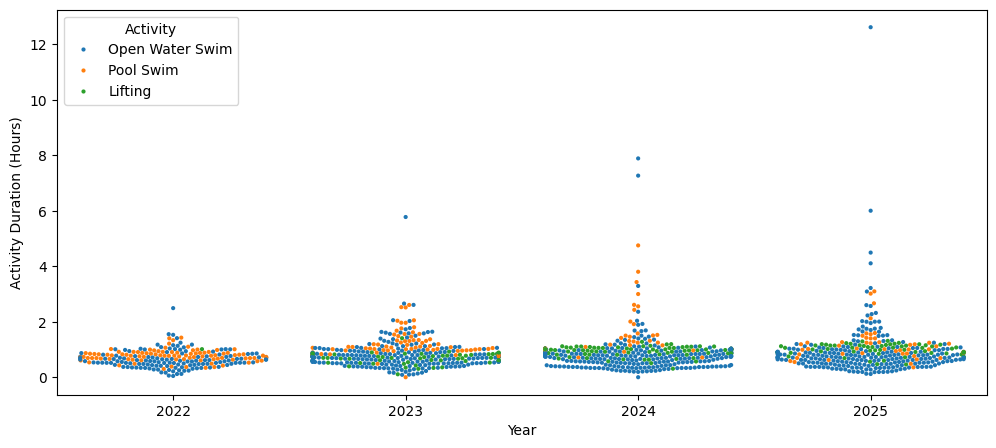

In [5]:
fix, ax = plt.subplots(figsize=(12,5))

plot = sns.swarmplot(
    data = df,
    x="year",
    y="duration_hr",
    hue = "type",
    size=3,
)
plt.ylabel("Activity Duration (Hours)")
plt.xlabel("Year")
plt.legend(title="Activity")

plt.show()

Lots of pool swimming in 2022, not as much open water compared to other years. No marathon swims that year
Plot is compressed a bit due to this query containing the long swims I did in each year. Since this analysis is focused on training specifically, I want to omit those.
Additionally, for each year, I will also omit every activity that I did AFTER my longest swim of the year. I tend to ramp my activity way down after I've completed my long swim for the year, mostly getting exercise in for manintenance and social benefits.

In [14]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(duration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE duration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(duration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year BETWEEN 2023 AND 2025
)
SELECT 
    a.startTimeLocal startTimeLocal,
    DAYOFYEAR(a.startTimeLocal) doy,
    DAYNAME(a.startTimeLocal) dayOfWeek,
    TIME_TO_SEC(TIME(a.startTimeLocal)) / 3600 AS time,
    CAST(a.year AS CHAR(10)) year,  
    a.type type,
    a.duration_hr duration_hr,
    SUM(a.duration_hr) OVER(PARTITION BY a.year ORDER BY a.startTimeLocal) cumulative_duration,
    a.distance distance 
FROM allTraining a
JOIN longSwimDate d
ON a.year=d.year
WHERE a.startTimeLocal<d.longSwimDay
"""

df=query_db(query, conn)


There's a lot to this query. 
First, there are 3 CTE's used:
 - **longSwims** - identify my longest swims in each year by duration.
 - **longSwimDate** - use the distances from **longSwims** to look up the date and time of those swims.
 - **allTraining** - get useful information about all of my activities in years 2023-2025, and categorize them by type.

The final query uses the dates in **longSwimDate** to filter my activities to just those that came before the longest swims in 2023-2025. Aside from basic information such as activity type, date, duration, distance, etc... I also grabbed a few pieces of information that I can use in the exploratory analysis, including:
 - day of the year
 - day of the week
 - activity start time (hour of day)
 - cumulative training hours per year

First, let's return to the swamplot for this filtered data to get a general sense of the trends.

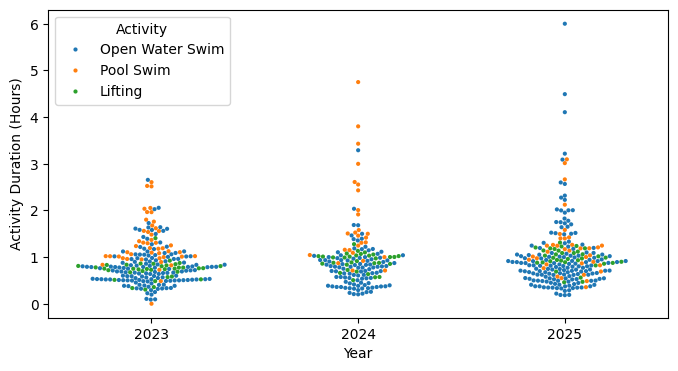

In [7]:
fix, ax = plt.subplots(figsize=(8,4))

plot = sns.swarmplot(
    data=df,
    y="duration_hr",
    x = "year",
    hue="type",
    size=3  # Treat year as categorical by converting to string
)
plt.ylabel("Activity Duration (Hours)")
plt.xlabel("Year")
plt.legend(title="Activity")
plt.show()


2023 - Lots of swims under 1 hour, most over 1 hour are in the pools. Longest training swim under 3 hours.
2024 - Longer training swims than 2023, mostly in the pool. 5 hour pool workout
2025 - Longer training swims than 2024, mostly in open water. 6 hour open water swim.

Number of lifting activities remains relatively stable throughout the three years.

Next, I will break this chart out by activity type to see if there are any trends that are hidden here by the sheer volume of data.

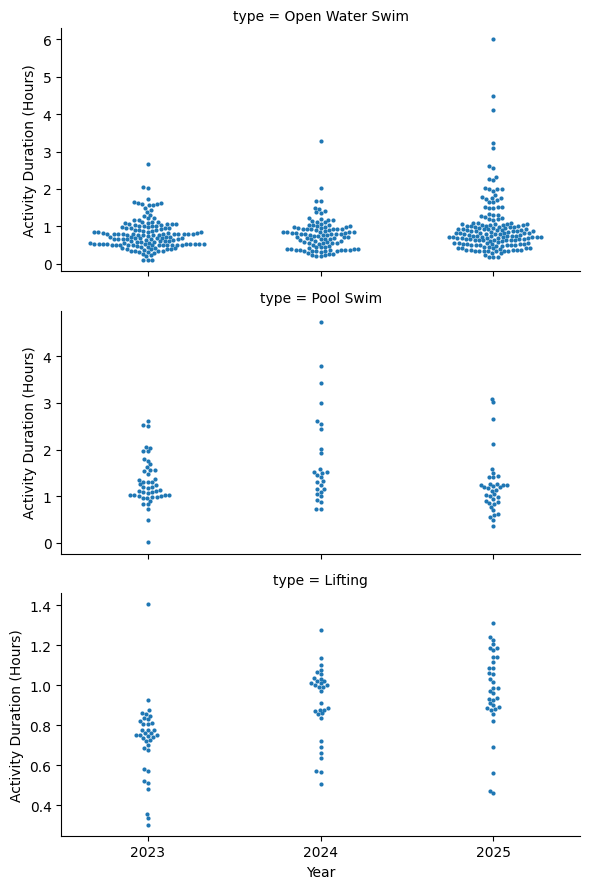

In [8]:
g = sns.FacetGrid(df, row = "type", height=3, aspect=2, sharey=False)
plot=g.map(
    sns.swarmplot,
    "year",
    "duration_hr",
    size=3  
    )
g=g.set_ylabels("Activity Duration (Hours)").set_xlabels("Year")

Looking at the data broken out this way, a few trends become very clear:
 - I did many more long pool swims and fewer open water swims in 2024. The reasons for this will become apparent later on.
 - My lifting volume was pretty consistent between the three years, but my sessions in 2025 were longer on average.

 Next, lets take a look at how my years progressed in terms of training volume by plotting the total number of training hours over the years up until the big events.

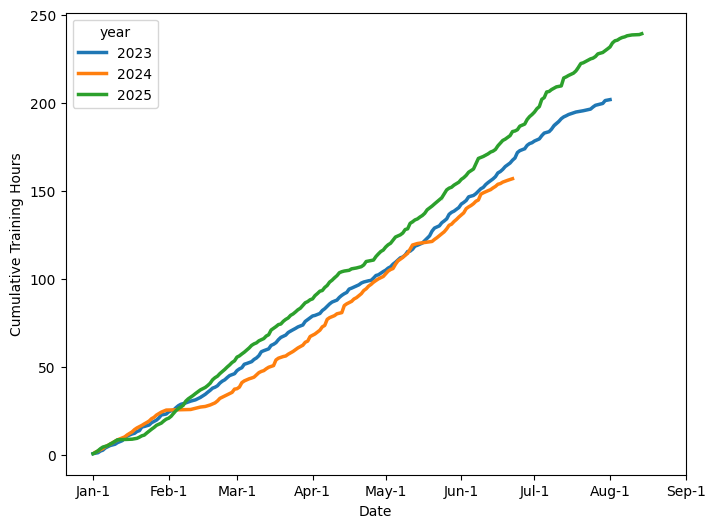

In [9]:
fix, ax = plt.subplots(figsize = (8,6))
plot = sns.lineplot(
    data=df,
    x="doy",
    y="cumulative_duration",
    hue="year",
    linewidth=2.5
)
ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244])
ax.set_xticklabels(
    [
        "Jan-1",
        "Feb-1",
        "Mar-1",
        "Apr-1",
        "May-1",
        "Jun-1",
        "Jul-1",
        "Aug-1",
        "Sep-1",
    ]
)
plt.ylabel("Cumulative Training Hours")
plt.xlabel("Date")
plt.show()

A few observations on this plot:
 - The outlier of these 3 lines is 2024. 
   - It ends the earliest because the main event that I had that were was much earlier than in the typical year - late June in 2024 vs early to mid-August in 2023 and 2025.
   - Due to this early date, 2024 also starts out with a slightly higher volume in January than the other years. However, it flattens out in February due to an injury (broken jaw) that prevented me from doing any physical activity for about a month.
   - Another side-effect of this early date was needing to shift all of my swimming volume earlier in the year by a couple of months. The water in the San Francisco Bay is obviously colder during the winter, and the swim that I was preparing for was particularly warm. Therefore, I did most of my long training swims in the pool, explaining a trend that was noted in the swarmplots above.
 - 2025 starts out slow in January before quickly becoming the highest volume year of the three by a pretty wide margin.
 - 2023 is still a high volume year despite the big event I was training for being the shortest. Perhaps I was a bit neurotic in preparing for my first marathon swim.

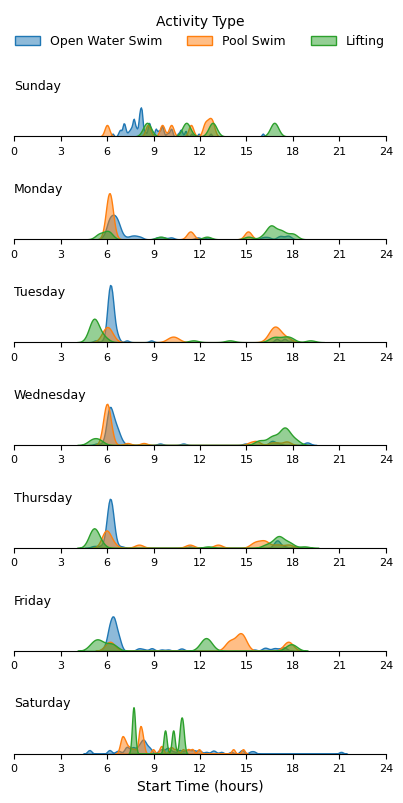

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

day_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday"
]

g = sns.FacetGrid(
    df,
    row="dayOfWeek",
    hue="type",
    row_order=day_order,
    aspect=4,
    height=1.1,
    sharex=True
)

# Filled density
g.map(
    sns.kdeplot,
    "time",
    fill=True,
    alpha=0.5,
    bw_adjust=0.1
)

# Clean up aesthetics
# First, remove the default facet titles
g.set_titles("")

# Add custom labels inside each subplot
for ax, day in zip(g.axes.flat, g.row_names):
    ax.text(
        x=0, 
        y=ax.get_ylim()[1]*0.95,  # near top
        s=day, 
        ha="left", 
        va="top",
        fontsize=9,
    )
g.set(
    yticks=[], 
    ylabel=""
    )
g.despine(left=True)
for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelsize=8)
    ax.set_xticks([0,3,6,9,12,15,18,21,24])
    ax.set_xticklabels([0,3,6,9,12,15,18,21,24])

plt.xlabel("Start Time (hours)")

handles, labels = g.axes[0,0].get_legend_handles_labels()

# Add a horizontal legend above all plots
plt.legend(
    handles=handles,
    labels=labels,
    title="Activity Type",
    loc="upper center",
    bbox_to_anchor=(0.5, 12.5),  # centered above
    ncol=len(labels),             # horizontal layout
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.show()


In [11]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(duration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE duration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(duration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        ROUND(CAST(minTemperature AS FLOAT)*1.8+32,1) temp
    FROM defaultdb.activities
    HAVING temp IS NOT NULL
    AND duration_hr between 0.5 and 5.9
    AND year BETWEEN 2023 AND 2025
    AND temp BETWEEN 50 and 65
),
temptraining AS(
    SELECT 
        CAST(a.year AS CHAR(10)) year,
        a.temp temp,
        a.duration_hr duration_hr,
        CASE
            WHEN duration_hr>1.5 AND temp=50 THEN 'wetsuit'
            WHEN duration_hr>2.5 AND temp=53.6 THEN 'wetsuit'
            WHEN duration_hr>3 AND temp<55.5 THEN 'wetsuit'
            ELSE NULL
        END AS wetsuit
    FROM allTraining a
    JOIN longSwimDate d
    ON a.year=d.year
    WHERE a.startTimeLocal<d.longSwimDay
    HAVING wetsuit IS NULL
)
SELECT year, temp, AVG(duration_hr) average_swim_length
FROM temptraining
GROUP BY year, temp

"""

df=query_db(query, conn)


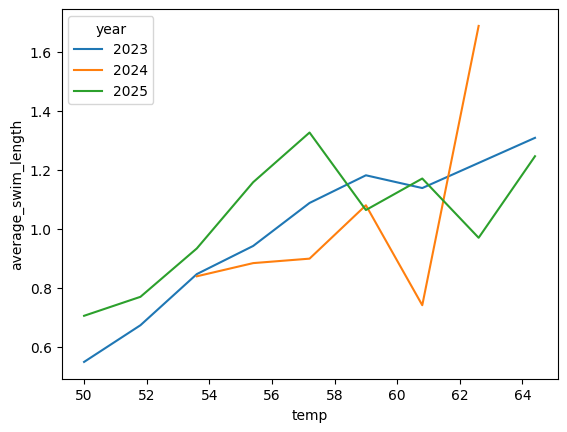

In [12]:
plot=sns.lineplot(
    data=df,
    x="temp",
    y="average_swim_length",
    hue="year",
)
# plt.ylim(0, 6.5)
plt.show()